In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing,  
import datetime as dt

# data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from operator import attrgetter
 

# machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [27]:
data = pd.read_csv("Year-2010-2011.csv", encoding = "ISO-8859-1")

In [7]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [9]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

In [11]:
data.describe()

,Quantity,Price,Customer ID
count,401605.000000,401605.000000,401605.000000
mean,12.183245,3.474100,15281.154341
std,250.282726,69.763952,1714.008869
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


There some negative values in the Quantity and Price features. It can't be possible. So I will filter the data greater than zero.

In [12]:
data = data[(data['Quantity'] > 0) & (data['Price'] > 0)]

 To work with the time series, we need to convert the type of related feature. The format should be as in the dataset

In [13]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%m/%d/%Y %H:%M')

Now, we need to create the cohort and order_month variables. The first one indicates the monthly cohort based on the first purchase date and the second one is the truncated month of the purchase date.

In [15]:
data['order_month'] = data['InvoiceDate'].dt.to_period('M')

In [16]:
data['cohort'] = data.groupby('Customer ID')['InvoiceDate'].transform('min').dt.to_period('M')

Now, we aggregate the data per cohort and order_month and count the number of unique customers in each group.

In [17]:
data_cohort = data.groupby(['cohort', 'order_month']).agg(n_customers=('Customer ID', 'nunique')).reset_index(drop=False)

In [18]:
data_cohort['period_number'] = (data_cohort.order_month - data_cohort.cohort).apply(attrgetter('n'))

In [19]:
data_cohort.head()

,cohort,order_month,n_customers,period_number
0,2010-12,2010-12,885,0
1,2010-12,2011-01,324,1
2,2010-12,2011-02,286,2
3,2010-12,2011-03,340,3
4,2010-12,2011-04,321,4


In [20]:
cohort_pivot = data_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')

In [21]:
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Actually, cohort_pivot shows us what we want to see. But we need to convert the table to see more clearly.

In [22]:
cohort_size = cohort_pivot.iloc[:, 0]

In [23]:
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

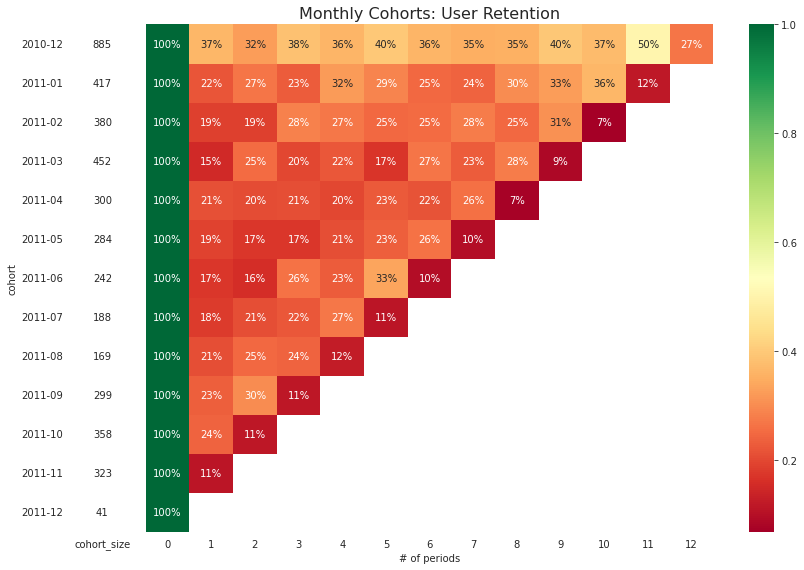

In [25]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_data = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()